## 1. Data Cleaning 

## 1.1 Data Imputation 

The first thing is to check is whether there is any obvious wrong records. Since we have the Siri's equation and BMI equation, they should reproduce each other after a certain transformation. According to Siri's equation, there is a linear relation between the percentage of body fat and the reciprocal of density, so we draw the plot (1/DENSITY vs. BODYFAT).

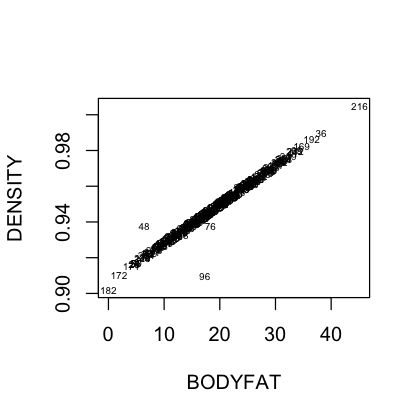

In [53]:
bodyfat <- read.table('../data/BodyFat.csv',header = T,sep = ',')
options(repr.plot.width=3.5, repr.plot.height=3.5)
plot(bodyfat$BODYFAT,1/bodyfat$DENSITY,type = 'n',xlab="BODYFAT",ylab="DENSITY")
text(bodyfat$BODYFAT,1/bodyfat$DENSITY,bodyfat$IDNO,cex=0.5)

The 182, 96, 76, 48 should be dropped since we can't decide if we should believe BODYFAT or DENSITY or neither. Accoding to the BMI equation (BMI=WEIGHT/HEIGHT^2), similarly, we draw the following plot to find anomalies (WEIGHT/HEIGHT^2 vs. ADIPOSITY).

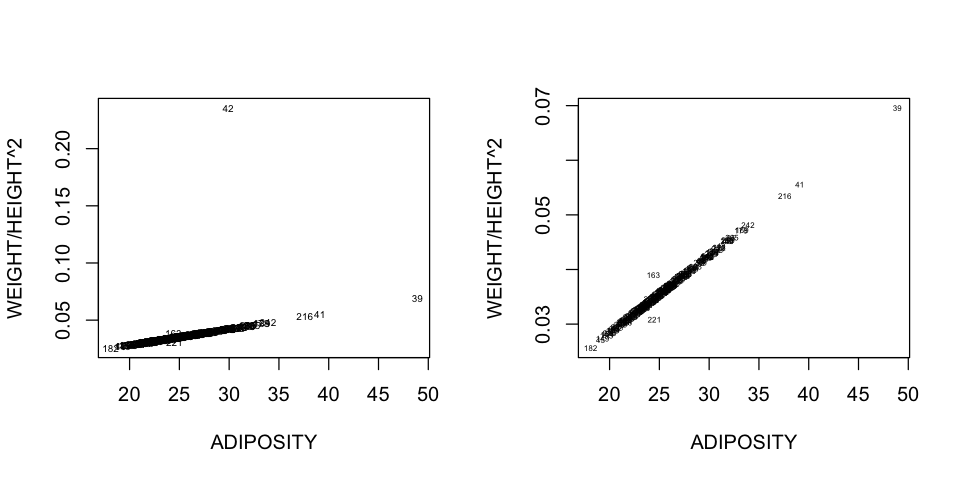

In [47]:
options(repr.plot.width=8, repr.plot.height=4)
par(mfrow=c(1,2))
plot(bodyfat$ADIPOSITY,bodyfat$WEIGHT/bodyfat$HEIGHT^2,type = 'n',xlab="ADIPOSITY",ylab="WEIGHT/HEIGHT^2")
text(bodyfat$ADIPOSITY,bodyfat$WEIGHT/bodyfat$HEIGHT^2,bodyfat$IDNO,cex=0.5)
plot(bodyfat[-42,]$ADIPOSITY,bodyfat[-42,]$WEIGHT/bodyfat[-42,]$HEIGHT^2,type = 'n',xlab="ADIPOSITY",ylab="WEIGHT/HEIGHT^2")
text(bodyfat[-42,]$ADIPOSITY,bodyfat[-42,]$WEIGHT/bodyfat[-42,]$HEIGHT^2,bodyfat[-42,]$IDNO,cex=0.4)

We can see that No. 42, 163 and 221 are far away from the theoretical line. We correct the mistake using their height and BMI. For 39th and 41th records, although they are far away from the majority, by double-checking their other features, we consider them valid and keep them.

In [56]:
bodyfat[c(39,41),]
bodyfat[42,'HEIGHT'] <- sqrt(bodyfat[42,'WEIGHT']/bodyfat[42,'ADIPOSITY']*703)
bodyfat[162,'HEIGHT'] <- sqrt(bodyfat[162,'WEIGHT']/bodyfat[162,'ADIPOSITY']*703) 
bodyfat[220,'HEIGHT'] <- sqrt(bodyfat[220,'WEIGHT']/bodyfat[220,'ADIPOSITY']*703) 

,IDNO,BODYFAT,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
39,39,33.8,1.0202,46,363.15,72.25,48.9,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4
41,41,33.1,1.0217,45,262.75,68.75,39.1,43.2,128.3,126.2,125.6,72.5,39.6,26.6,36.4,32.7,21.4


## 1.2 Outlier Detection

We then check whether there are any unusual values of the response (i.e. bodyfat). There are two skeptical records (No. 172 and 216).

In [49]:
bodyfat[c(172,216),]

,IDNO,BODYFAT,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
172,172,1.9,1.0983,35,125.75,65.5,20.6,34.0,90.8,75.0,89.2,50.0,34.8,22.0,24.8,25.9,16.9
216,216,45.1,0.9950,51,219.00,64.0,37.6,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4


,IDNO,BODYFAT,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
39,39,33.8,1.0202,46,363.15,72.25,48.9,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4
41,41,33.1,1.0217,45,262.75,68.75,39.1,43.2,128.3,126.2,125.6,72.5,39.6,26.6,36.4,32.7,21.4


According to , the reasonable range of bodyfat is from 2$\%$ to 50$\%$, so we keep both of them.

## Outliers

Intuitively, if some record is far from the majority, it may be wrong. Or even it is a correct record, it may not come from the same population we are interested in.
The following step is to check outliers in the dataset. It is difficult to plot high dimension scatter plot so here we look at pairwise scatter plots.

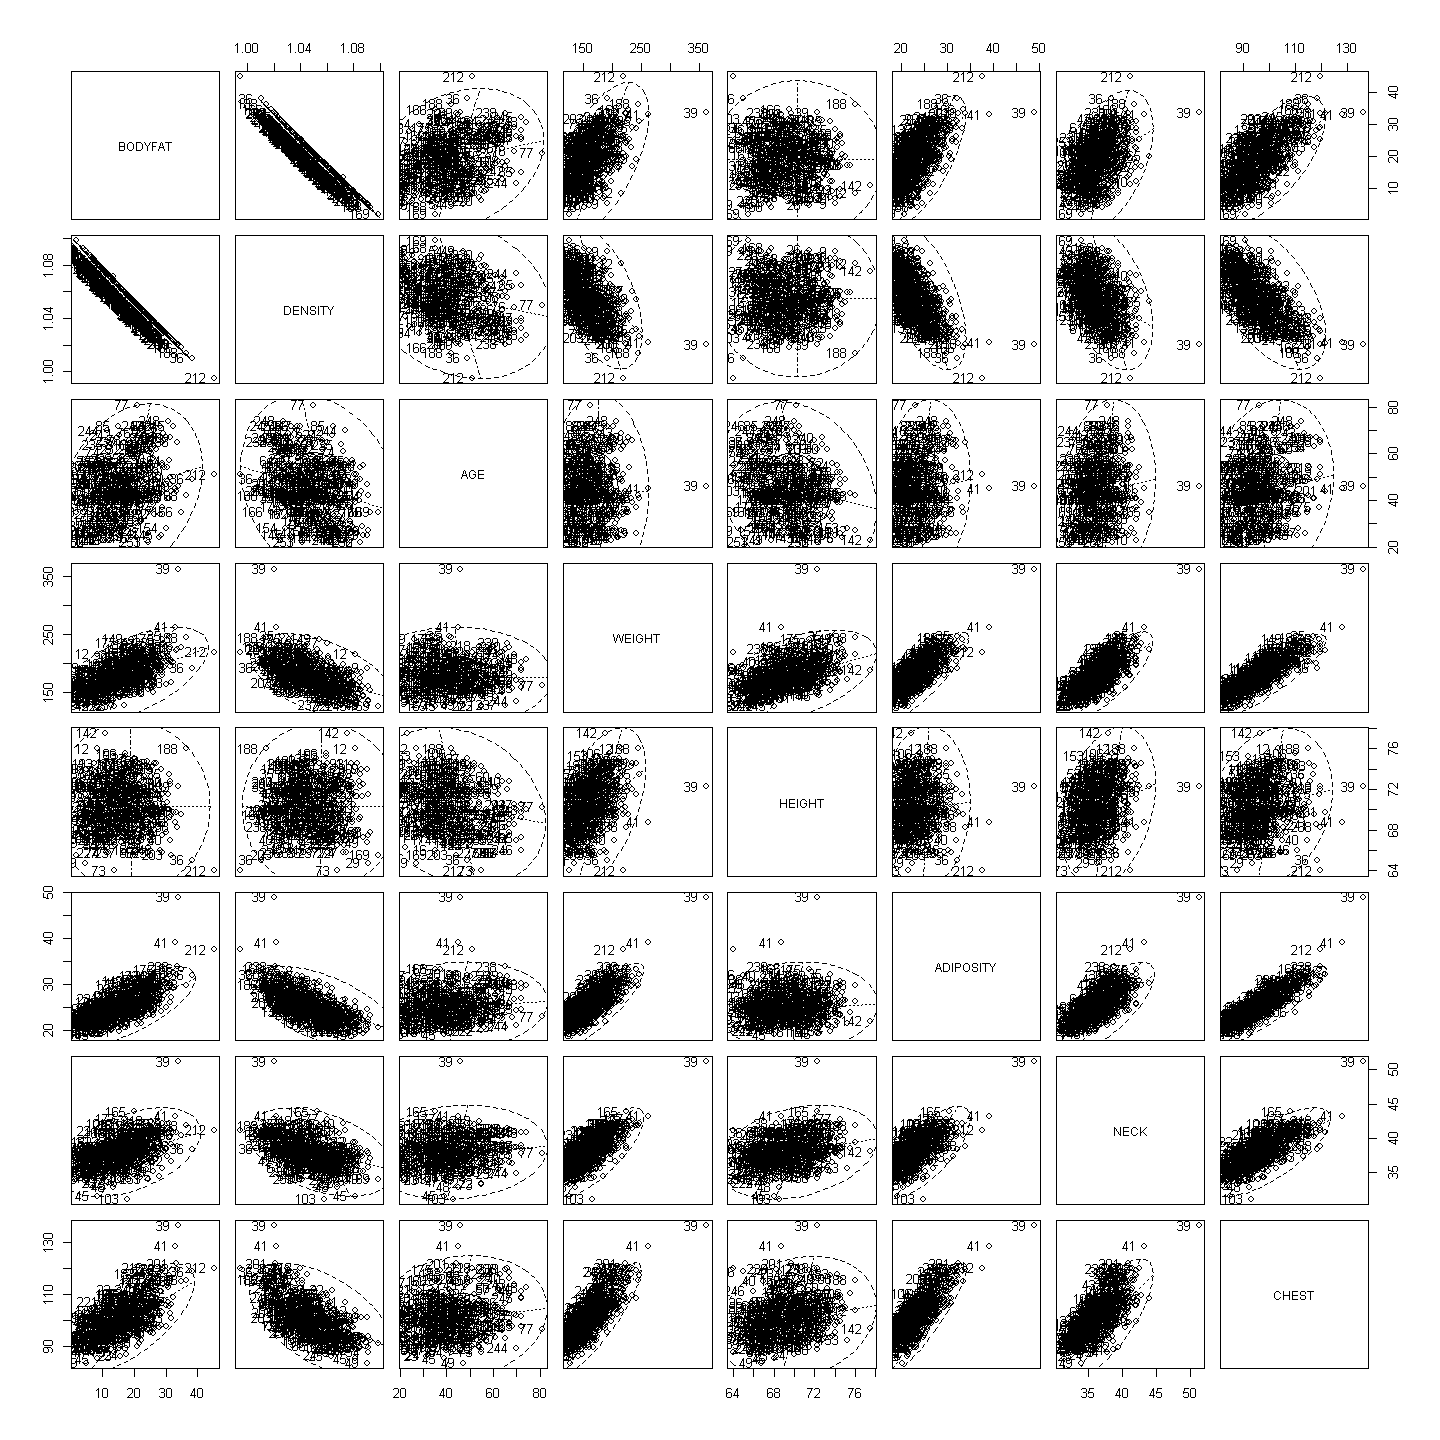

In [22]:
require("MVA")
require("biwt")
options(repr.plot.width=12, repr.plot.height=12)
pairs(bodyfat[-c(48,76,96,182),2:9], 
      panel = function(x,y, ...) {
        text(x, y, IDNO,cex = 1, pos = 2)
        bvbox(cbind(x,y), add = TRUE,method = "robust")
      })

The 39,41 and 212 are always lay out of the dashed line. We will check them to see if there is any mistake

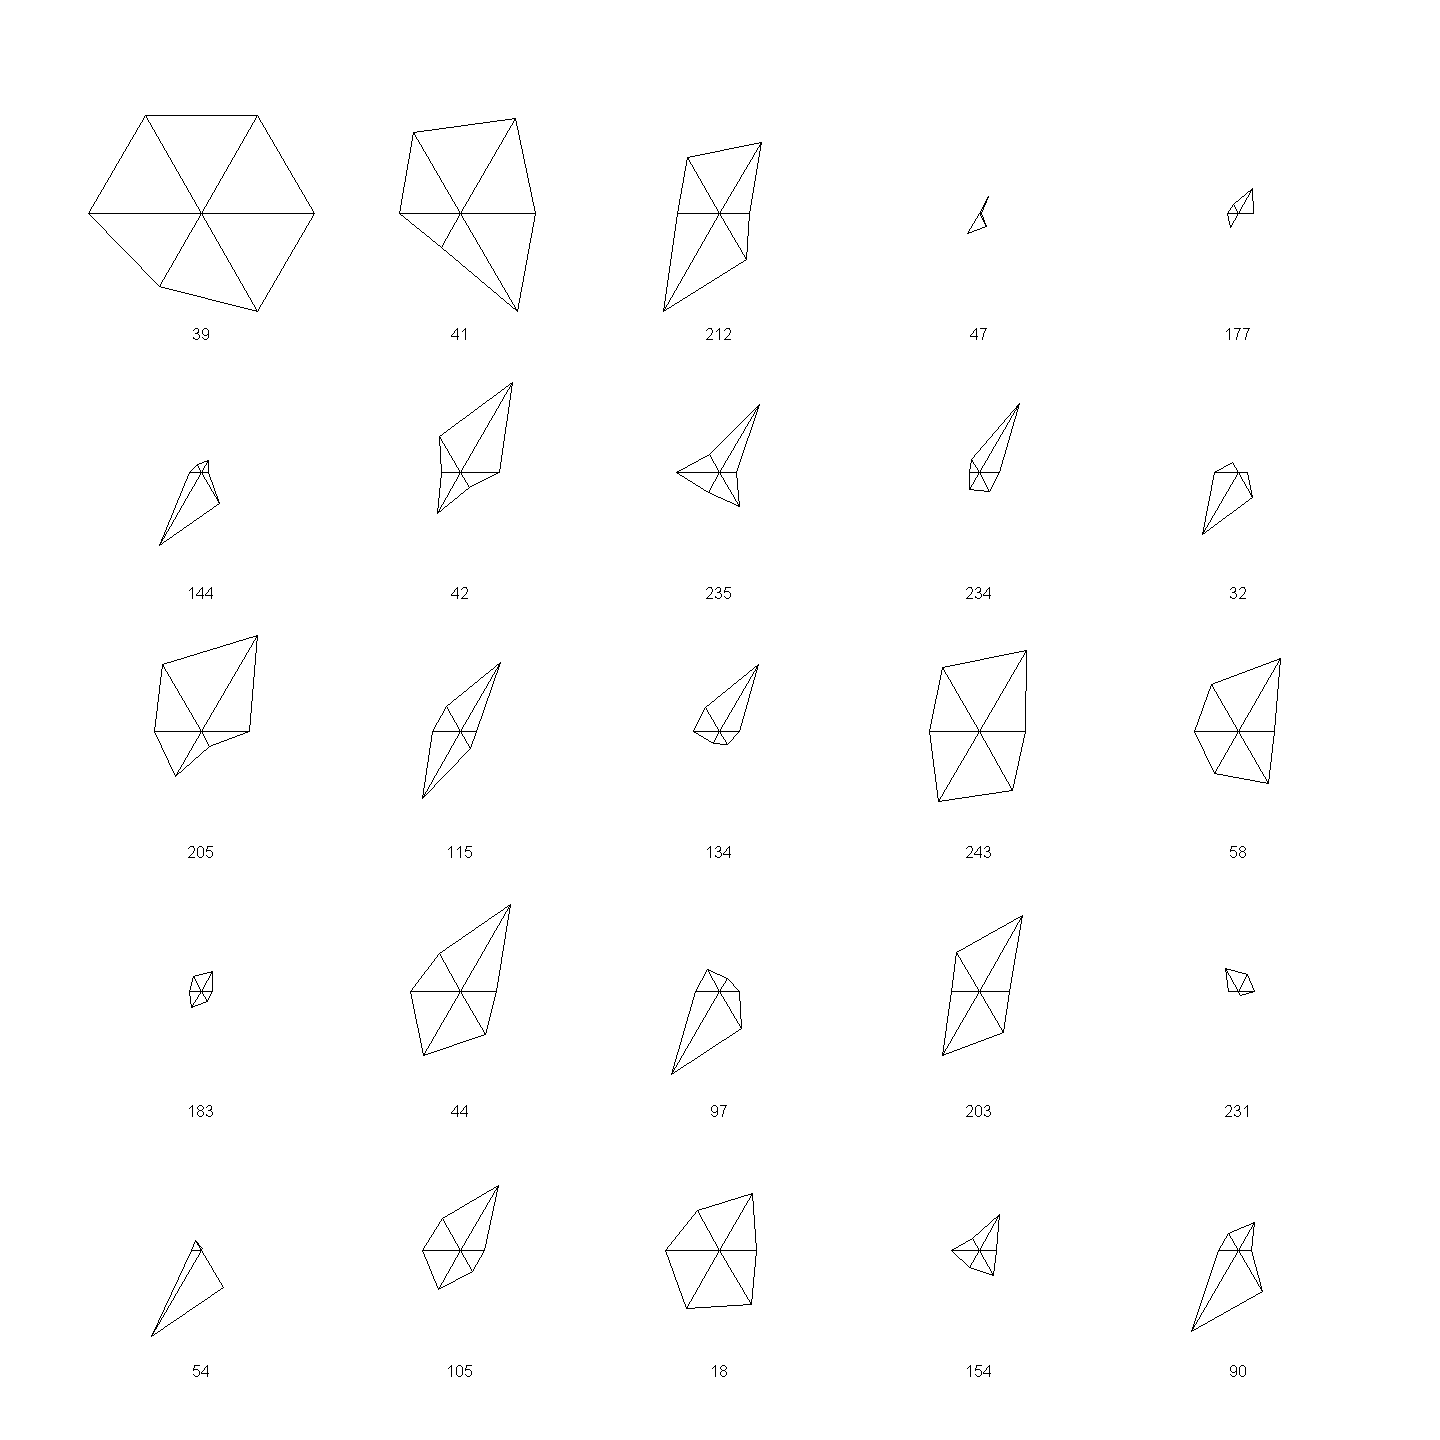

In [23]:
set.seed(2)
x <- sample(1:252,22)
y <- x[!x %in% c(48,76,96,182)]

subdata <- bodyfat[unique(c(39,41,212,y)),c('IDNO',"ADIPOSITY","BODYFAT","CHEST","NECK",'HEIGHT','WRIST')]
stars(subdata[,c("ADIPOSITY","BODYFAT","CHEST","NECK",'HEIGHT','WRIST')],
      nrow=5,ncol=5,labels=subdata$IDNO)

The first 3 are the suspects, each hexagon represents the person's ADIPOSITY,BODYFAT,CHEST,NECK,HEIGHT,WRIST. We can see 39 is a big guy in every aspect so the data collected are consistent to each other. 212 has the same 'shape' with many other persons like 203 so we think it is also a correct record. 41 may be a problem since it doesn't look like others. But the left lower diagonal represents 'HEIGHT' which is already crosschecked before.